# NST Directly on Traces
Get the reconstruction after latent space traversal then adjust it according to the web_content_model

In [1]:
import scripts.init_gpu as init_gpu
import scripts.init_dataset as init_dataset
from scripts.triplet_functions import n_neurons
import pandas as pd


init_gpu.initialize_gpus()

locations = ['LOC1', 'LOC2']

print("Loading Dataset...")
# load the dataset
df = pd.read_csv(
    f"../dataset/processed/{locations[0]}-{locations[1]}-scaled-balanced.csv")

length = len(df.columns) - 2  # subtract the two label columns

# get train-test set
train_df, test_df, train_web_samples, test_web_samples = init_dataset.get_sample(
    df, locations, range(1500), 1200)

train_df.head()

2024-11-25 13:08:12.119264: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-25 13:08:12.126467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732500492.134890  109437 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732500492.137385  109437 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 13:08:12.145948: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  2
Loading Dataset...
Training Websites: [1309, 228, 51, 563, 501, 457, 285, 209, 1385, 1116, 178, 1209, 864, 65, 61, 191, 447, 476, 1034, 1232, 54, 1149, 407, 1466, 1330, 1436, 1490, 859, 451, 919, 1206, 569, 13, 326, 1429, 865, 696, 1468, 318, 440, 689, 1492, 189, 778, 198, 735, 704, 1236, 541, 88, 940, 1098, 255, 775, 161, 1130, 600, 1287, 1266, 740, 1182, 393, 142, 93, 1354, 466, 592, 163, 1482, 206, 1456, 1462, 928, 1301, 747, 333, 758, 727, 429, 1372, 546, 1399, 1327, 146, 1247, 1300, 350, 1093, 1495, 334, 946, 777, 552, 1310, 1140, 449, 1402, 664, 114, 469, 1486, 646, 821, 548, 135, 432, 1161, 644, 435, 1342, 1022, 810, 1316, 939, 292, 542, 1493, 505, 1478, 1103, 538, 1197, 877, 1195, 817, 741, 1404, 283, 1043, 1010, 186, 96, 224, 313, 1285, 327, 1487, 1221, 130, 788, 781, 1220, 958, 1083, 514, 1133, 23, 234, 1099, 1419, 1312, 1463, 1498, 601, 890, 323, 929, 6, 539, 1025, 365, 1039, 217, 1280, 611, 1308, 1338, 1415, 1477, 1366, 765, 330, 1104, 1086, 1, 1226, 

/home/asil0892/doh_traffic_analysis/code/scripts/init_dataset.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.sort_values(by=["Location"], inplace=True)


,Location,Website,0,1,2,3,4,5,6,7,...,116,117,118,119,120,121,122,123,124,125
0,LOC1,0,-1.086861,0.690199,0.647933,0.201517,0.207139,-0.031855,-0.316768,0.824649,...,0.055571,0.160203,0.121677,0.093533,0.09274,0.057062,0.155991,0.109839,0.086282,0.08604
1,LOC1,1005,1.095547,-1.585943,0.647933,0.343653,0.207139,-0.031855,-0.316768,0.824649,...,0.055571,0.160203,0.121677,0.093533,0.09274,0.057062,0.155991,0.109839,0.086282,0.08604
2,LOC1,1005,1.095547,0.780047,-1.972790,0.343653,0.207139,-0.031855,-0.316768,0.824649,...,0.055571,0.160203,0.121677,0.093533,0.09274,0.057062,0.155991,0.109839,0.086282,0.08604
3,LOC1,1005,-1.086861,0.690199,0.647933,0.343653,0.207139,-0.031855,-0.316768,0.824649,...,0.055571,0.160203,0.121677,0.093533,0.09274,0.057062,0.155991,0.109839,0.086282,0.08604
4,LOC1,1005,1.095547,0.780047,0.183501,-0.828965,-2.083179,-0.031855,-0.316768,0.824649,...,0.055571,0.160203,0.121677,0.093533,0.09274,0.057062,0.155991,0.109839,0.086282,0.08604


In [2]:
import tensorflow as tf
from scripts.train_vae import VAE, Sampling, ConvVAE, ConvVAE_BatchNorm

# load models

latent_dim = 96
vae_model = tf.keras.models.load_model("../models/vae/ci_vae/ConvBased/domain_and_class/checkpoints/LOC1-LOC2-e880-mse1-kl0.01-cl1.0-ConvBatchNorm-ldim96-hdim128.keras", custom_objects={'ConvVAE_BatchNorm': ConvVAE_BatchNorm, 'Sampling': Sampling})
web_model = tf.keras.models.load_model(f"../models/website/{locations[0]}-{locations[1]}-baseGRU-epochs100-train_samples1200-triplet_samples5-domain_invariant-l1.keras")
location_classifier = tf.keras.models.load_model(f"../models/classification/location/dense.keras")
latent_location_classifier = tf.keras.models.load_model(f"../models/classification/location/latent_ci_vae-e880_both_classifier.keras")
triplet_location_classifier = tf.keras.models.load_model(f"../models/classification/location/triplet_classifier.keras")

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1732500528.027406  109437 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1732500528.027500  109437 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5696 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1732500528.027599  109437 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 1
I0000 00:00:1732500528.027654  109437 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 19892 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:71:00.0, compute capability: 8.9


# Get Location Hyperplane

In [23]:
from scripts.classification import evaluate_classification_model, preprocess_data_for_platform_classification
from sklearn import svm
import numpy as np


def get_z_embeddings(data, vae_model=vae_model):
    embeddings = []
    chunk_size = 200
    for i in range(0, len(data), chunk_size):
        chunk = data[i:i+chunk_size]
        _, _, transformed_chunk = vae_model.encode(chunk)
        embeddings.append(transformed_chunk)

    return np.vstack(embeddings)

X_train, X_test, y_train, y_test, le = preprocess_data_for_platform_classification(train_df, test_df)
X_train_latent = get_z_embeddings(X_train)
X_test_latent = get_z_embeddings(X_test)



svm_loc_clf = svm.LinearSVC()
evaluate_classification_model(X_train_latent, y_train, X_test_latent, y_test, svm_loc_clf)


weights = svm_loc_clf.coef_.flatten()
bias = svm_loc_clf.intercept_.flatten()

# Normalize the weight vector
w_norm = weights / np.linalg.norm(weights)

Accuracy: 82.54, F1 Score:  82.43, Precision:  83.39, Recall:  82.54


In [4]:
def jump_to_other_side(z, w, b, alpha=0.1, mirrored=True):
    """
    Jump directly to the other side of the hyperplane.
    
    Parameters:
    - z: The current latent vector (numpy array).
    - w: The normal vector of the hyperplane.
    - b: The bias term of the hyperplane.
    - alpha: Additional step size to cross to the other side.
    
    Returns:
    - z_new: The updated latent vector on the other side.
    """
    # Compute the current value of the decision function
    decision_value = np.dot(w, z) + b
    
    # Compute the displacement to the hyperplane
    delta_z = -decision_value / np.dot(w, w) * w
    
    if mirrored:
        # mirror image of the point
        z_new = z + 2 * delta_z
    else: 
        # Add an additional step to cross the hyperplane
        z_new = z + delta_z + alpha * w

    return z_new

# Synthesis Model

In [64]:
import numpy as np
import tensorflow as tf

class TrafficSynthesisModel(tf.keras.Model):
    def __init__(self, website_model, location_classifier, v_source,  v_mirrored, target_location):
        super(TrafficSynthesisModel, self).__init__()
        
        # Models
        self.website_model = website_model
        self.location_classifier = location_classifier
        
        # Fix the weights of the other models
        self._freeze_models()

        # Data and embeddings
        self.v_synth = tf.Variable(v_mirrored)
        self.website_embedding = website_model(v_source)
        
        # Location target
        self.target_location = self._set_target_location(target_location)


        # Hyperparameters
        self.epsilon = 1e-6 # To avoid division by zero in log calculations
        self.max_annealing_epoch = 500
        self.max_reg_weight = 0.01
        self.max_website_weight = 1

        # logging the losses
        self.website_losses = []
        self.location_losses = []
    def _freeze_models(self):
        self.website_model.trainable = False
        self.location_classifier.trainable = False

    def _set_target_location(self, target_location):
        if target_location == 'LOC1':
            return tf.constant(0.0, dtype=tf.float32)
        elif target_location == 'LOC2':
            return tf.constant(1.0, dtype=tf.float32)
        else:
            raise Exception('Invalid Location')

    def get_location_classifier_weight(self, loss):
        if loss < 0.5:
            return 0
        return 1
        
    def get_regularization_weight(self, epoch):
        return self.max_reg_weight * min(epoch / self.max_annealing_epoch, 1.0)
    
    def get_website_weight(self, epoch):
        return self.max_website_weight * min(epoch / self.max_annealing_epoch, 1.0)

    def get_euclidean_distance(self, vector_a, vector_b):
        return tf.reduce_mean(tf.square(vector_a - vector_b))

    def compute_losses(self, epoch):
        """Calculate and return individual loss components as a dictionary."""
        
        losses = {}
        
        synth_triplet_embedding = self.website_model(self.v_synth)
        
        # Website reconstruction loss
        losses["website_loss"] = self.get_euclidean_distance(self.website_embedding, synth_triplet_embedding)

        # Synthesized trace location classification loss
        predicted_location = tf.clip_by_value(self.location_classifier(self.v_synth)[0][0], self.epsilon, 1 - self.epsilon)
        # losses["location_loss"] = - (self.target_location * tf.math.log(predicted_location) + (1 - self.target_location) * tf.math.log(1 - predicted_location))
        losses["location_loss"] = 1 - predicted_location

        self.website_losses.append(losses["website_loss"])
        self.location_losses.append(losses["location_loss"])

        # Compute total loss by summing all loss components
        total_loss = (
            # losses['location_loss'] +
            losses['website_loss'] 
        )
        return total_loss, losses

    def train_step(self, epoch):
        with tf.GradientTape() as tape:
            total_loss, losses = self.compute_losses(epoch)
        
        gradients = tape.gradient(total_loss, [self.v_synth])

        # gradient clipping
        gradients, global_norm = tf.clip_by_global_norm(gradients, clip_norm=1.0)

        
        self.optimizer.apply_gradients(zip(gradients, [self.v_synth]))
        
        return total_loss, losses

    def fit(self, epochs=1000, lr=0.01):
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        
        for epoch in range(epochs):
            total_loss, losses = self.train_step(epoch)

            # TODO: Implement early stop based on some critieria

            if epoch % 100 == 0:
                float_losses = {k: v.numpy() for k, v in losses.items()}
                print(f"Epoch {epoch}, Total Loss: {total_loss.numpy()}")
                print(f"\tLosses: {float_losses}")
        
        return self.v_synth.numpy(), losses['website_loss'].numpy(), losses["location_loss"].numpy()


In [76]:
import random
from scripts.classification import preprocess_data_for_web_classification

random_seed = 42
target_location = 'LOC2'
source_location = 'LOC1'

source_traces = []
synthesized_traces = []
mirrored_traces = []

target_website = 8
target_data = test_df[(test_df['Website'] == target_website) & (test_df['Location'] == target_location)].iloc[:, 2:].to_numpy()

_, _, _, _, le = preprocess_data_for_web_classification(test_df, source_location, target_location) 

i = 0
num_samples = 4
while i != num_samples:
    print(f"{i+1} of {num_samples}...")


    source_trace = test_df[(test_df['Location'] == source_location) & (
        test_df['Website'] == target_website)].iloc[:, 2:].sample()

    source_trace = source_trace.to_numpy().reshape(1, length, 1)

    source_latent, _, _ = vae_model.encode(source_trace)
    
    # TODO: Add some loop to make the latent embedding go further away from the hyperplane boundary
    mirrored_latent = jump_to_other_side(source_latent[0], w_norm, bias, mirrored=True)

    mirrored_trace = vae_model.decode(mirrored_latent.numpy().reshape(1, -1))
    
    print(f"mirrored latent location prediction: {svm_loc_clf.predict(mirrored_latent.numpy().reshape(1, -1))}")
    print(f"mirrored trace reconstructed location prediction: {location_classifier.predict(mirrored_trace.numpy().reshape(1, -1))}")
    
    # initialize model
    print("Initializing TSM Model...")
    tsm_model = TrafficSynthesisModel(web_model, location_classifier, source_trace, mirrored_trace, target_location)
    
    
    # synthesize
    epochs = 1000
    lr = 0.01
    
    
    print("Synthesizing Trace...")
    synthesized_vector, web_loss, location_loss = tsm_model.fit(epochs=epochs, lr=lr)

    # if not a good synthesis: Based on location classification
    # if (latent_classification_loss > 0.2) or (location_trace_classification_loss > 0.4):
    #     print("Neglecting this one, not a good synthesis...")
    #     continue
    
    mirrored_traces.append(mirrored_trace)
    source_traces.append(source_trace.reshape(1, -1))
    synthesized_traces.append(synthesized_vector)
    i += 1

synthesized_traces = np.array(synthesized_traces).reshape(num_samples, length)

1 of 4...
mirrored latent location prediction: [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
mirrored trace reconstructed location prediction: [[0.8424356]]
Initializing TSM Model...
Synthesizing Trace...
Epoch 0, Total Loss: 0.021269267424941063
	Losses: {'website_loss': 0.021269267, 'location_loss': 0.1575644}
Epoch 100, Total Loss: 0.0064689829014241695
	Losses: {'website_loss': 0.006468983, 'location_loss': 0.16622978}
Epoch 200, Total Loss: 0.002576177939772606
	Losses: {'website_loss': 0.002576178, 'location_loss': 0.50550604}
Epoch 300, Total Loss: 0.002231198363006115
	Losses: {'website_loss': 0.0022311984, 'location_loss': 0.55770826}
Epoch 400, Total Loss: 0.001943994895555079
	Losses: {'website_loss': 0.0019439949, 'location_loss': 0.52171916}
Epoch 500, Total Loss: 0.001562012592330575
	Losses: {'website_loss': 0.0015620126, 'location_loss': 0.48542142}
Epoch 600, Total Loss: 0.0013663399731740355
	Losses: {'website_loss': 0.00136634, 'location_loss': 0.367651}
Epoch 700, Total

In [70]:
def get_nearest_neighbour(target_data, synth):
    distances = tf.sqrt(tf.reduce_mean(tf.square(target_data - synth.reshape(1, -1)), axis=1))

    # Find the index of the closest embedding
    nearest_neighbor_index = tf.argmin(distances)

    # Get the nearest neighbor embedding and its distance
    nearest_neighbor = target_data[nearest_neighbor_index]
    nearest_distance = distances[nearest_neighbor_index]
    return nearest_neighbor, nearest_distance

def get_nearest_neighbour_latent(target_data, synth):
    target_latent_embeddings, _, _ = vae_model.encode(target_data)
    z_new, _, _ = vae_model.encode(synth.reshape(1, -1))
    distances = tf.sqrt(tf.reduce_mean(tf.square(target_latent_embeddings - z_new), axis=1))

    # Find the index of the closest embedding
    nearest_neighbor_index = tf.argmin(distances)

    # Get the nearest neighbor embedding and its distance
    nearest_neighbor = target_latent_embeddings[nearest_neighbor_index].numpy()
    nearest_distance = distances[nearest_neighbor_index]
    
    return target_data[nearest_neighbor_index], nearest_neighbor, nearest_distance


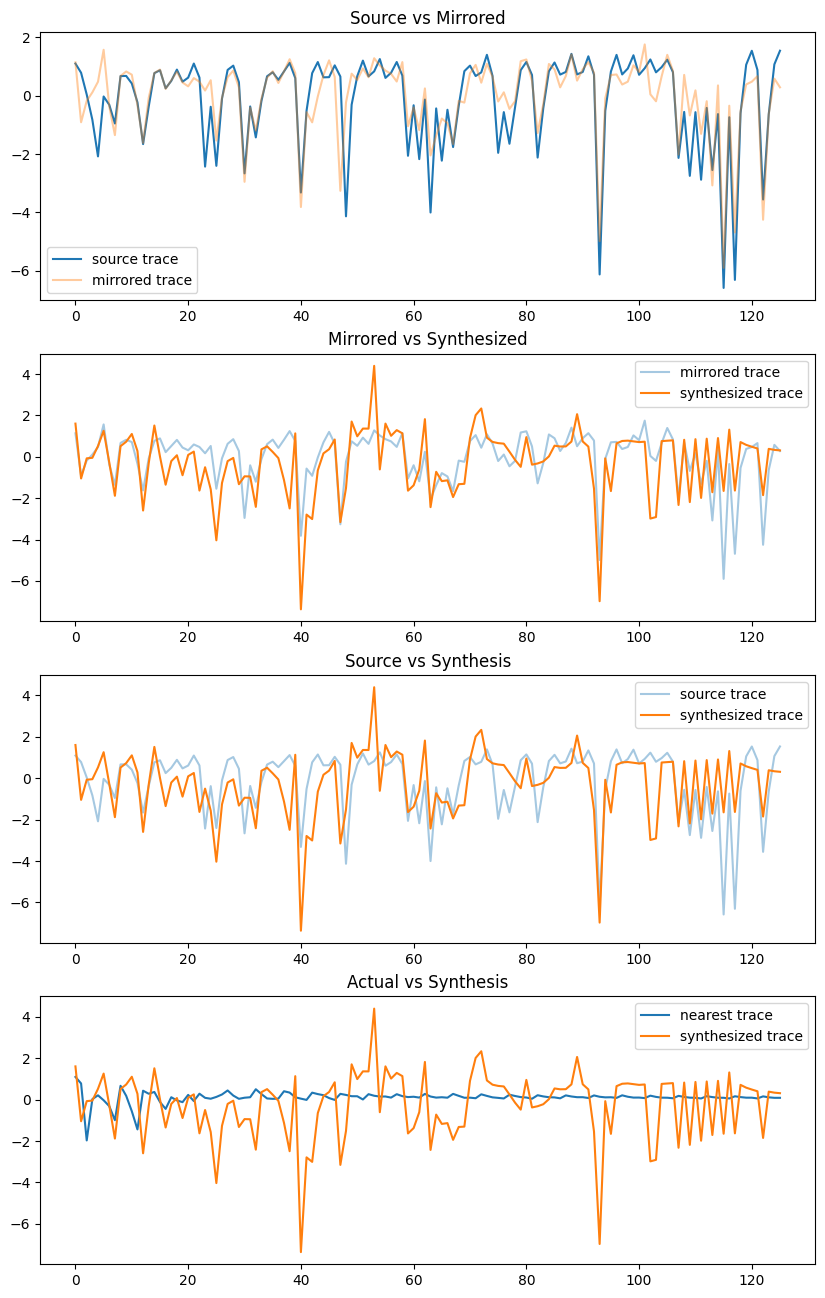

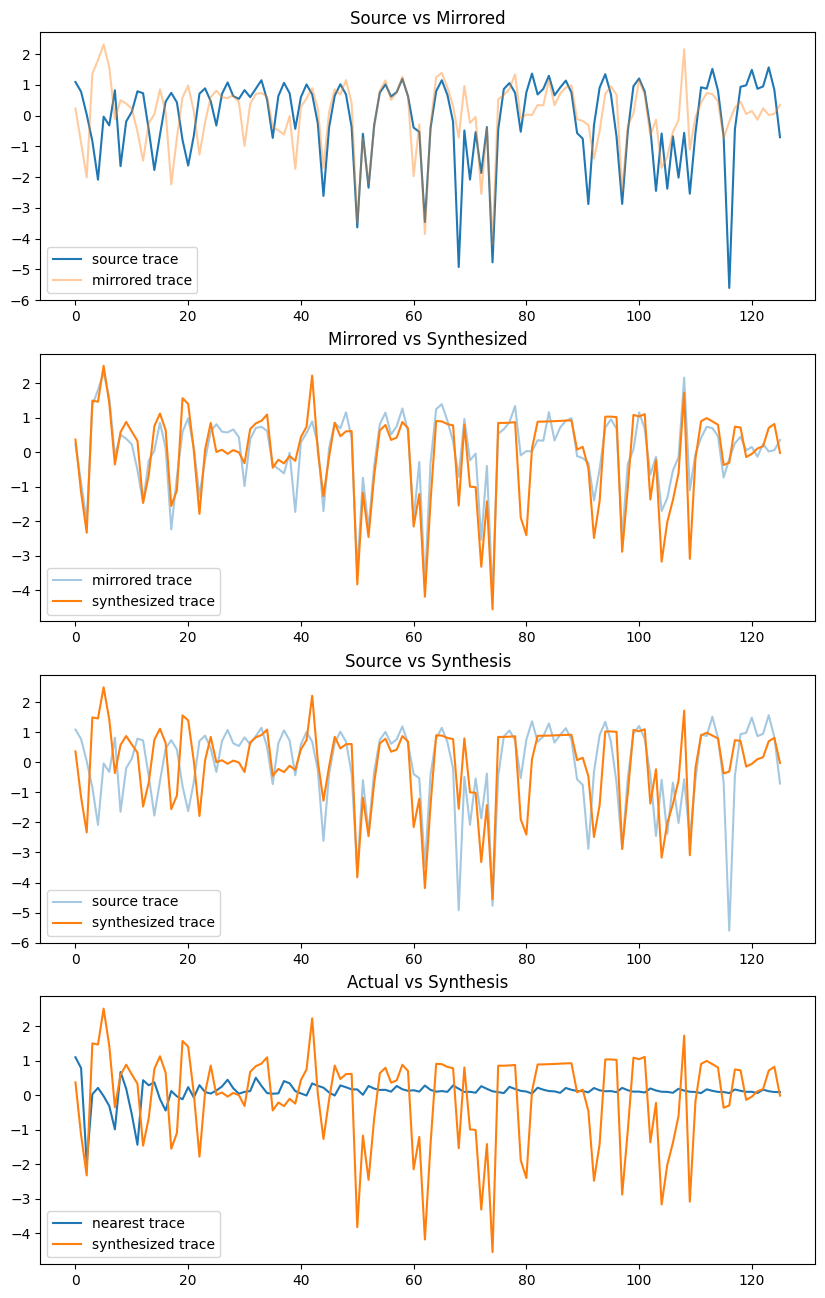

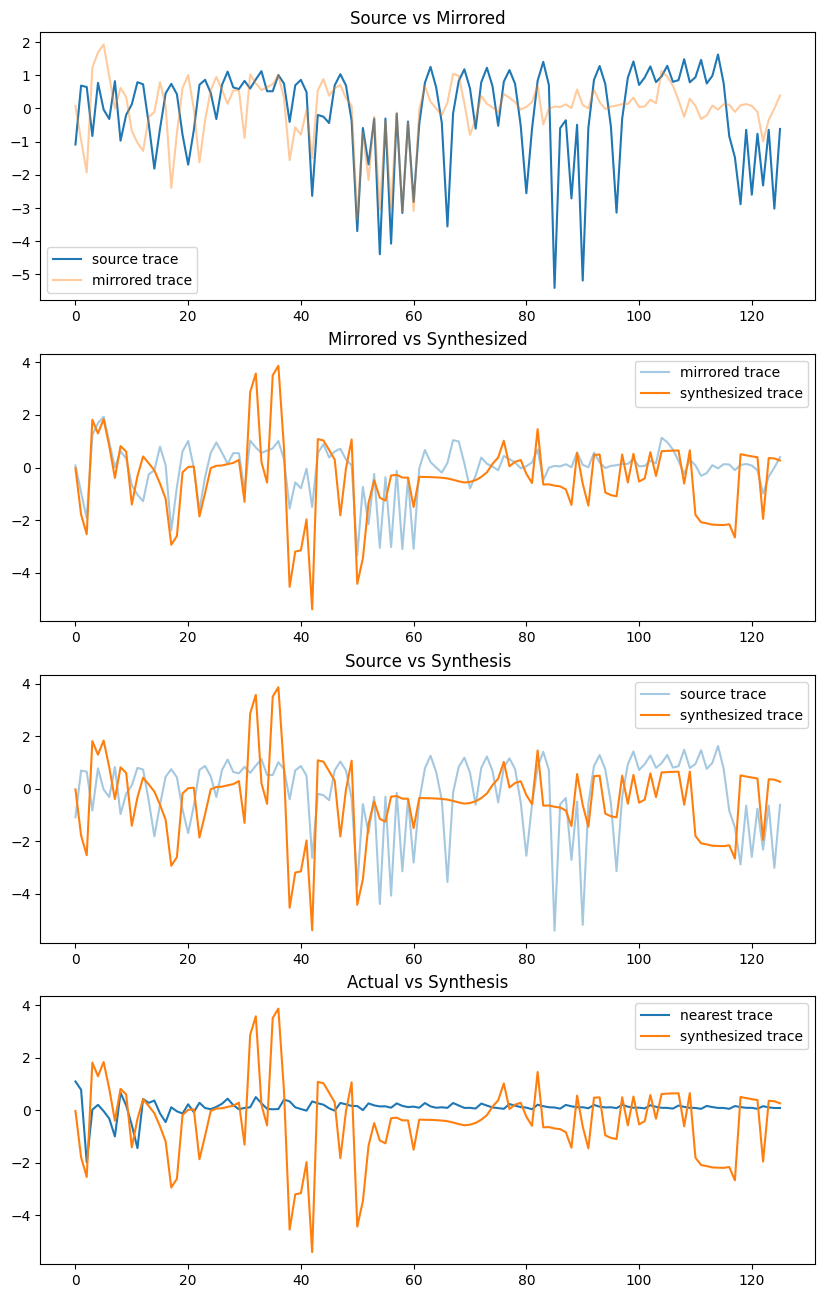

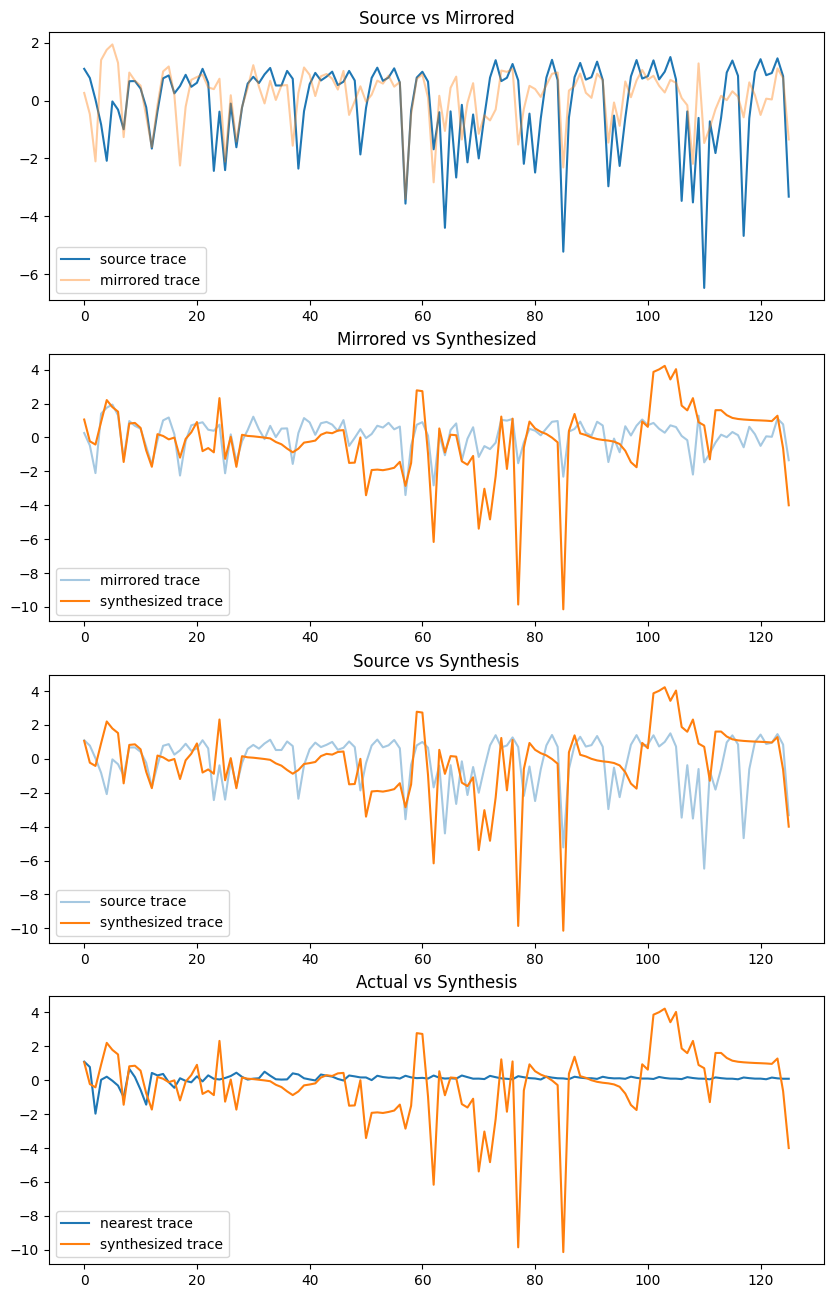

In [77]:
import matplotlib.pyplot as plt


for i in range(num_samples):
    plt.figure(figsize=(10, 16))
    plt.subplot(4, 1, 1)
    plt.plot(source_traces[i][0], label='source trace')
    plt.plot(mirrored_traces[i][0], label='mirrored trace', alpha=0.4)
    plt.legend()
    plt.title("Source vs Mirrored")
    
    plt.subplot(4, 1, 2)
    plt.plot(mirrored_traces[i][0], label='mirrored trace', alpha=0.4)
    plt.plot(synthesized_traces[i], label='synthesized trace')
    plt.legend()
    plt.title("Mirrored vs Synthesized")

    plt.subplot(4, 1, 3)
    plt.plot(source_traces[i][0], label='source trace', alpha=0.4)
    plt.plot(synthesized_traces[i], label='synthesized trace')
    plt.legend()
    plt.title("Source vs Synthesis")



    plt.subplot(4, 1, 4)
    
    
    nearest_trace, _, =  get_nearest_neighbour(target_data, synthesized_traces[i])
    plt.plot(nearest_trace, label='nearest trace')
    plt.plot(synthesized_traces[i], label='synthesized trace')
    plt.legend()
    plt.title("Actual vs Synthesis")
    
    
    plt.show()
    plt.close()